In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Union

from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd
import seaborn as sns
import json

import nest_asyncio
nest_asyncio.apply()

from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo, ImageNode
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.schema import QueryBundle


import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
claude_mm_default = BasicAnthropicLLM(model='claude-3-5-sonnet-20240620', temperature = 0.0)

In [4]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [5]:
fig_num = 2

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

In [6]:
query_tool = handler.query_engine_tool(metadata_filters=filters)

In [7]:
class Variable(BaseModel):
    """
    A variable is a quantity that is varied across the experimental conditions. It can be numeric, categorical, or both.
    Categories usually map to some visual feature like color, line style, or marker shape.
    Numerica variables usually map to coordinate axes.
    """
    name: str = Field(..., description="The name of the variable")
    categorical: bool = Field(..., description="Whether the variable has categorical axes")
    numeric: bool = Field(..., description="Whether the variable has numeric axes")

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]
    text_discrepancies: list[str] = Field(default_factory=list, description="Any discrepancies between the text information and the image information that we should note when referencing the text in the future (e.g. persistent or occasional mis-references).")

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class CategoryMap(BaseModel):
    type: str = Field(
        ...,
        description="The single visual signifier that this map corresponds to (e.g. color, marker, linestyle, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable in this specific plot. If the label is color, give the RGB value as a list of floats in [0,1]."
    )

class Legend(BaseModel):
    """
    A legend is a set of category maps that map the categorical variables to their visual labels for the entire figure. Only include properties that apply to the figure as a whole.
    """
    category_maps: list[CategoryMap] = Field(
        default_factory=list,
        description="The category maps for the legend of the figure."
    )

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    legend: Legend



In [8]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [9]:
response = query_tool(prompt)
nodes = response.raw_output.source_nodesv
figure_struct = output_parser.parse(response.content)

In [10]:
nodes

[NodeWithScore(node=TextNode(id_='816f492a-fb49-4eab-8c9c-7c0a71364724', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'Light delivery and imaging', 'experimental_variable_entities': ['light pulse duration', 'wavelength', 'power', 'photocurrent strength', 'light intensity'], 'fig_refs': ['Supplemental Figure 5', 'Figure 2e']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='a4ba317c-ca68-4aad-bc84-1fb48df2d70a', node_type=None, metadata={}, hash=None)}, text='Light delivery and imaging\n\nPatch-clamp recordings were done with short light pulses to measure photocurrents. Light pulse duration, wavelength, and power were varied depending on the experiment (as describe

In [11]:
# find figure image
for node in nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))
        source_figure_summary = node.node.text

In [12]:
fig_description = f"{figure_struct.name}"
fig_description += f"\n\tLegend: {figure_struct.legend.category_maps}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name} (plot.text_discrepancies: {plot.text_discrepancies})"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 2
	Legend: [CategoryMap(type='color', values={'CheRiff': [0.5, 0.5, 0.5], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [0.5, 0.5, 0.5], '11_10': [0.0, 1.0, 1.0], '12_10': [1.0, 0.0, 1.0], '25_9': [0.0, 1.0, 1.0], '10_10': [1.0, 1.0, 0.0], '15_10': [0.0, 0.0, 1.0], '28_10': [1.0, 0.5, 0.0], '21_10': [0.5, 0.0, 0.5], '3_10': [1.0, 0.0, 0.0]})]
	Panel: a

		Plot: Current traces and cell images (plot.text_discrepancies: [])
			independent_variables=[Variable(name='ChR variant', categorical=True, numeric=False), Variable(name='Time', categorical=False, numeric=True)] dependent_variables=[Variable(name='Current', categorical=False, numeric=True), Variable(name='Fluorescence', categorical=False, numeric=True)]
	Panel: b

		Plot: Photocurrent strength with different wavelength excitation (plot.text_discrepancies: [])
			independent_variables=[Variable(name='ChR variant', categorical=True, numeric=False), Variable(name='Wavelength', categorical=True, numeric=True)] dependent_variables=[Variable(

In [28]:
# select panel d (only one plot in panel)
panel = figure_struct.panels[3]
plot = panel.plots[0]
exp = plot.experiments[0]

In [29]:
class BoundingBox(BaseModel):
    left_x: float = Field(default = 0.0, description="The x-coordinate of the left side of the bounding box in the range 0.0 to 1.0")
    upper_y: float = Field(default = 0.0, description="The y-coordinate of the top side of the bounding box in the range 0.0 to 1.0")
    right_x: float = Field(default = 1.0, description="The x-coordinate of the right side of the bounding box in the range 0.0 to 1.0")
    lower_y: float = Field(default = 1.0, description="The y-coordinate of the bottom side of the bounding box")

In [30]:
output_parser = PydanticOutputParser(output_cls=BoundingBox)

In [31]:
PLOT_CROP_PROMPT = """
Provide a bounding box for panel {panel_name} (plot title/description: {plot_name}) in the provided figure. 
Be liberal with padding, we'd rather have extra that lose part of the panel."""

prompt = PromptTemplate(
    PLOT_CROP_PROMPT.format(panel_name=panel.name, plot_name=plot.name), 
    output_parser=output_parser
).format(llm=plotreader._MM_LLM)

In [32]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure]
)

In [33]:
bbox = output_parser.parse(response.content[0].text)

In [34]:
padding = 0.1
bbox_cropped = BoundingBox()
bbox_cropped.left_x = np.max([0, bbox.left_x - padding])
bbox_cropped.upper_y = np.max([0, bbox.upper_y - padding])
bbox_cropped.right_x = np.min([1, bbox.right_x + padding])
bbox_cropped.lower_y = np.min([1, bbox.lower_y + padding])
bbox_cropped

BoundingBox(left_x=0.0, upper_y=0.5800000000000001, right_x=0.43000000000000005, lower_y=1.0)

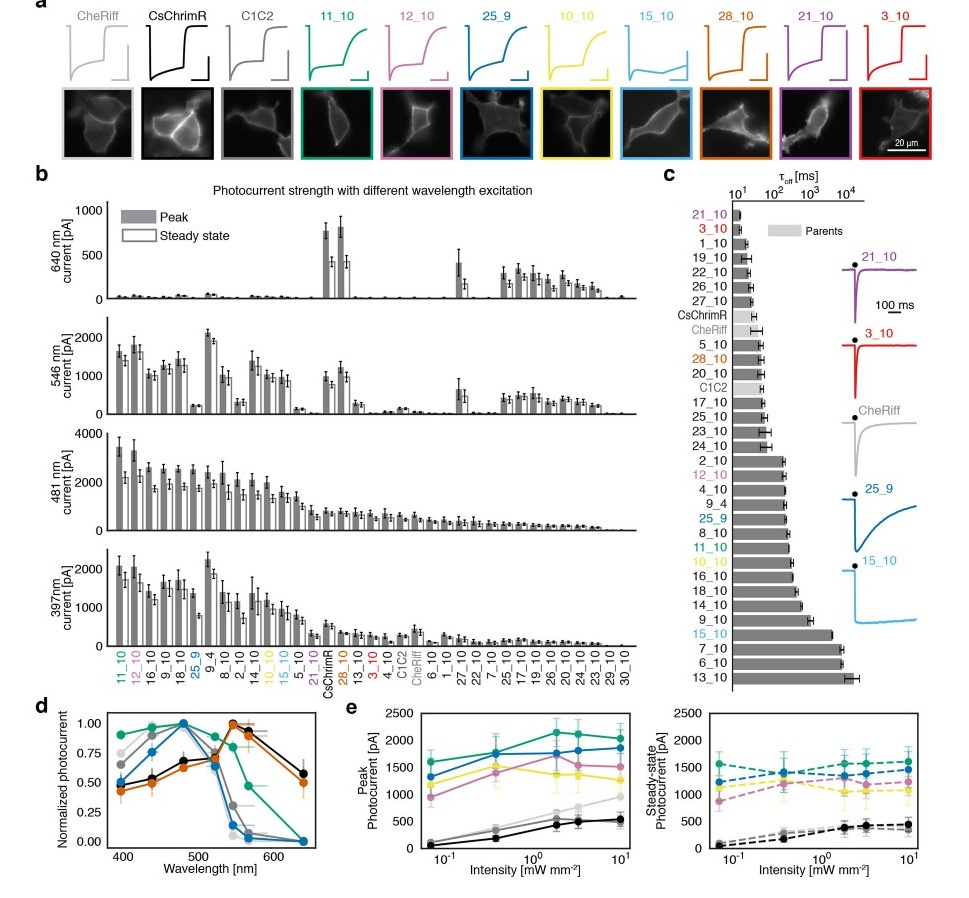

In [35]:
source_figure

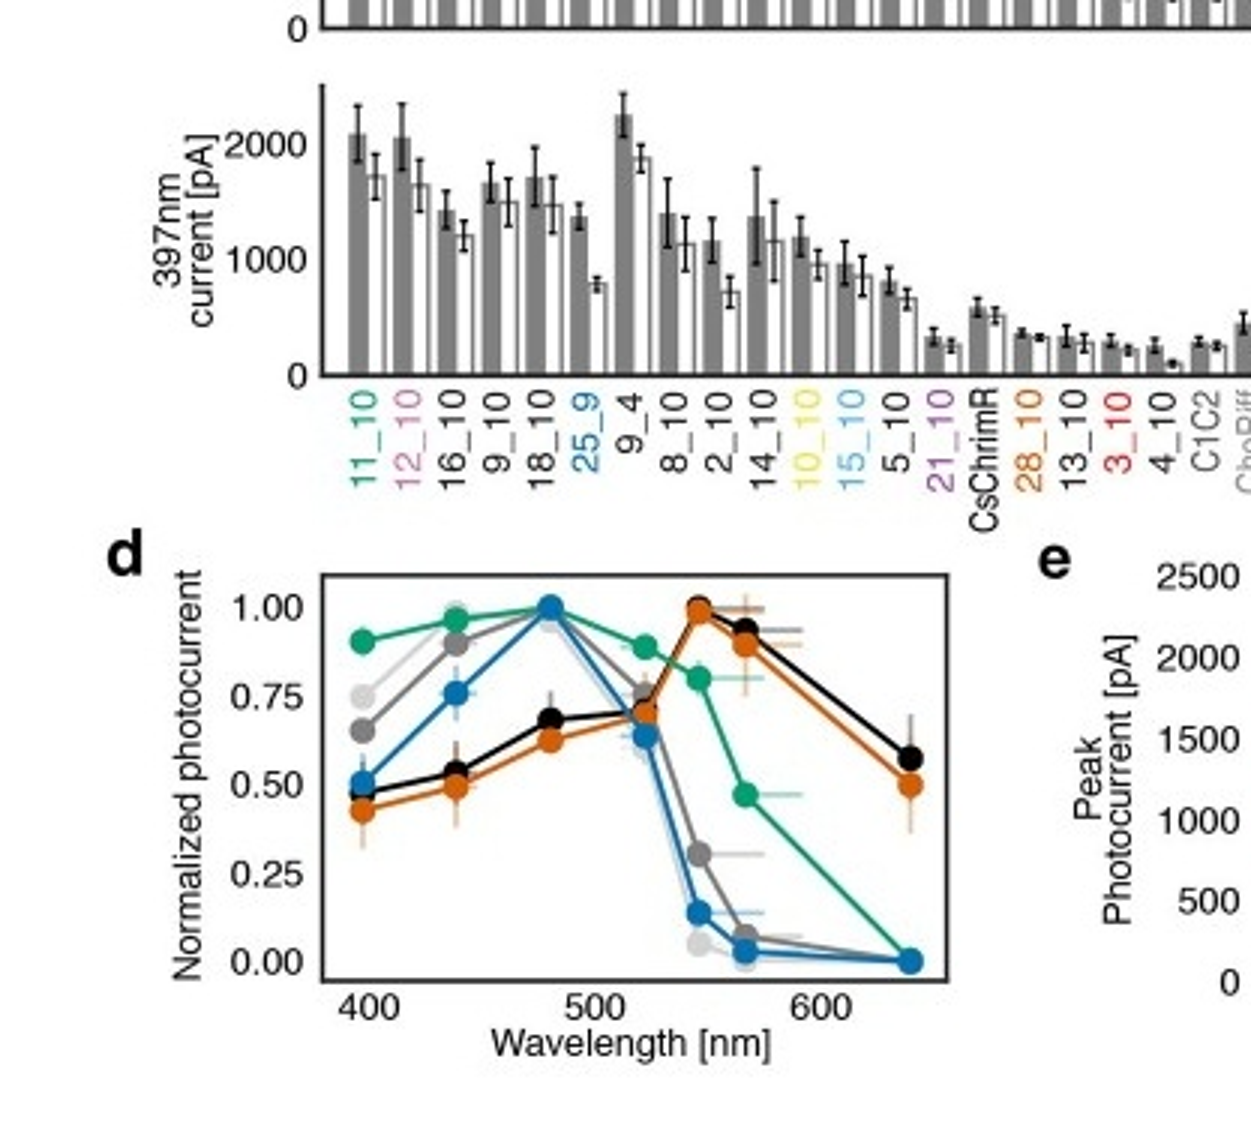

In [36]:
# use pillow to crop the image
fig_size = source_figure.size
bbox_px_vals = [bbox_cropped.left_x*fig_size[0], bbox_cropped.upper_y*fig_size[1], bbox_cropped.right_x*fig_size[0], bbox_cropped.lower_y*fig_size[1]]

# Crop the image using the extracted coordinates
cropped_img = source_figure.crop(bbox_px_vals)
# resize the image to closer to original size
cropped_img_size = cropped_img.size
cropped_img_zoomed = cropped_img.resize([pix_count * 3 for pix_count in cropped_img_size])
cropped_img_zoomed.save("cropped_img.png")
cropped_img = Image.open("cropped_img.png")
cropped_img

In [37]:
# make image node from cropped image
from plotreader.utils import image_to_base64

# convert PIL image to b64 encoded string
cropped_img_b64 = image_to_base64(cropped_img)

cropped_img_node = ImageNode(
    image=cropped_img_b64,
    image_url=None,
    metadata={
        "fig_refs": [f"Figure {fig_num}{panel.name}"],
    }
)

In [38]:
nodes.append(cropped_img_node)

In [39]:
fig_filter =  MetadataFilter(
    key="fig_refs", 
    value=f'Figure {fig_num}',
    operator=FilterOperator.TEXT_MATCH_LIST
)

entity_filters = [
    MetadataFilter(
        key="experimental_variable_entities",
        value = iv.name,
        operator=FilterOperator.TEXT_MATCH_LIST
    ) for iv in plot.experiments[0].independent_variables
]

# entity_filters += [
#     MetadataFilter(
#         key="experimental_variable_entities",
#         value = dv.name,
#         operator=FilterOperator.TEXT_MATCH_LIST
#     ) for dv in plot.experiments[0].dependent_variables
# ]

filters = MetadataFilters(
    filters= [fig_filter] + entity_filters,
    condition=FilterCondition.OR
)

retriever = handler.vector_index().as_retriever(
    similarity_top_k=10,
    filters=filters
)

In [40]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a full Figure {fig_num} from a scientific paper and information extracted from the text of that paper.
Focus on panel {panel_name}, plot {plot_name}.
Are there any major discrepancies between the text and the image - e.g. the text is not referencing the correct panel or plot or label?
Be as nit-picky as possible. Do not miss any mistakes
""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Structured representation of the plot experiment:
{plot_desc}

Retrieved text information regarding the figure as a whole:
{context}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

nodes = retriever.retrieve(FIGURE_SUMMARY_PROMPT)
text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=10)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n\n".join(
    [r.get_content(metadata_mode=MetadataMode.LLM) for r in rerankded_text_nodes]
)

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context)
prompt = PromptTemplate(
    full_prompt_formatted,
).format(llm=plotreader._MM_LLM)

In [41]:
response = claude_mm_default.message(
    full_prompt_formatted,
    images = [source_figure]
)
details_text = response.content[0].text
print(details_text)

Based on my analysis of panel d in Figure 2 and the provided text information, there do not appear to be any major discrepancies between the text and the image. The text accurately describes the plot of normalized photocurrent vs wavelength shown in panel d. Specifically:

1. The text mentions that ChR_28_10 has a red-shifted spectrum matching CsChrimR, which is consistent with the red line in the plot.

2. It states that ChR_11_10 has a broad activation spectrum with similar current strength from 400-546 nm, which matches the purple line in the plot.

3. It describes ChR_25_9 as having a narrow activation spectrum with a peak at 481 nm, corresponding to the blue line in the plot.

4. The parental ChRs (CheRiff, CsChrimR, C1C2) are also shown for comparison, as mentioned in the text.

5. The wavelengths specified in the text (400-640 nm) match the x-axis range.

6. The y-axis shows normalized photocurrent as described.

The text and figure appear to be in good agreement, with no obviou

In [42]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a full Figure {fig_num} from a scientific paper, a cropped version with a panel of interest ({fig_num}{panel_name}), as well as additoinal context.
Your job is to extract all detailed information about the experimental variables used in a particular plot in the panel: {plot_name}.
The most important thing is that you include all details about the variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES.
Be extra close attention to the "Potential Discrepancies and Notes" section.
IMPORTANT:
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)
""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Retrieved text information regarding the figure as a whole:
{context}

Potential Discrepancies and Notes:
{details_text}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=3)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n\n".join(
    [r.get_content(metadata_mode=MetadataMode.LLM) for r in rerankded_text_nodes]
)

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context, details_text=details_text)
prompt = PromptTemplate(
    full_prompt_formatted,
).format(llm=plotreader._MM_LLM)

In [43]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure, cropped_img]
)
details_text = response.content[0].text
print(details_text)

Based on the provided image and context, here are the detailed experimental variables for the normalized photocurrent vs wavelength plot in panel 2d:

1. Dependent variable: Normalized photocurrent (y-axis)
   - Range: 0.00 to 1.00
   - Units: Arbitrary units (normalized)

2. Independent variable: Wavelength (x-axis)
   - Range: 400 nm to 600 nm
   - Units: Nanometers (nm)

3. ChR variants tested (each represented by a different colored line):
   - ChR_11_10 (teal)
   - ChR_25_9 (blue)
   - ChR_28_10 (orange)
   - CheRiff (light gray)
   - C1C2 (dark gray)
   - CsChrimR (black)

4. Data points:
   - 7 wavelengths measured: 397 nm, 439 nm, 481 nm, 523 nm, 546 nm, 567 nm, and 640 nm
   - Represented as circles ('o') on the plot

5. Light pulse parameters:
   - Duration: 0.5 s
   - Intensity: 1.3 mW mm^-2 (matched across all wavelengths)

6. Error bars: Shown as vertical lines extending from each data point

7. Normalization: Each ChR variant's photocurrent is normalized to its maximum va

In [44]:
class CategoryMap(BaseModel):
    type: str = Field(
        ...,
        description="The single visual signifier that this map corresponds to (e.g. color, marker, linestyle, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable in this specific plot. If the label is color, give the RGB value as a list of floats in [0,1]."
    )

class NumericAxis(BaseModel):
    """
    A numeric measurement is a quantity that is measured or a statistic of measurements.
    """
    unit: str = Field(default= "", description="The unit of the numeric measurement.")
    is_log: bool = Field(default=False, description="Whether the numeric axis is on a log scale.")
    major_tick_mark_values: list[float] = Field(default_factory = list, description="The numeric values of the major tick mark locations for the variable.")

class Variable(BaseModel):
    """
    A variable is a quantity that is controlled (independent variable) or measured/summarized from measurements (dependent variable). It can be numeric, categorical, or both.
    """
    name: str = Field(..., description="The name of the variable")
    category_maps: list[CategoryMap] = Field(
        default_factory=list,
        description="Maps that essentially define the legend for this variable's categories to their visual labels in the plot if any exist."
    )
    numeric_axis: NumericAxis = Field(
        default_factory=NumericAxis,
        description="The numeric axis for this variable if it exists."
    )


class Parameter(BaseModel):
    """
    A parameter is a feature of the experiment that is necessary to know to fully describe it, but is not varied across the experimental conditions and therefore only takes one value for all data in the plot.
    """
    name: str = Field(..., description="The name of the parameter")
    value: Union[str, float] = Field(..., description="The value of the parameter")

class Experiment(BaseModel):
    """
    An experiment is a set of experimental conditions that are varied across the experimental conditions as well as additional parameters relevant to the experimetnal configuration.
    """
    independent_variables: list[Variable] = Field(default_factory=list, description="The independent variables of the experiment. Together these define the experimental conditions. They can be numeric or categorical or both.")
    dependent_variables: list[Variable] = Field(default_factory=list, description="The dependent variables of the experiment. These are often raw or summarized statistics of the data/measurements. They can be numeric or categorical or both.")
    parameters: list[Parameter] = Field(default_factory=list, description="The parameters of the experiment. These are quantities that are necessary to know to fully describe the experimental design, but are not varied across the experimental conditions.")
    description: str = Field(..., description="A description of the experiment. This should be a short description that is easy to understand and interpret.")
    result: str = Field(..., description="The result of the experiment. This should be a short description that is easy to understand and interpret.")
    other_info: str = Field(..., description="Any other information about the experiment that is relevant to the experimental design or methodology.")
    plot_type: str = Field(..., description="The type of plot (e.g. line plot, scatter plot, bar chart, etc.)")



In [45]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a panel of interest (Figure {fig_num}{panel_name}; cropped from full figure {fig_num}) and information from that paper regarding the figure.
Your job is to extract detailed information about the experiment in the plot: {plot_name}.
Focus on being detailed and exact. DO NOT SUMMARIZE SETS OF QUANTITIES. Any text information could contain errors. Use all available information across images and text to resolve discrepancies.

IMPORTANT:
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)
    ALL INFORMATION RELEVANT FOR DESCRIBING OR POTTING THE DATA SHOULD BE IN VARIABLE CLASSES.
    VARIABLES CAN HAVE BOTH NUMERIC AXES AND CATEGORICAL MAPS.
    Note: you can have trouble with colors. Do you absolute best to match the exact colors in the plot.

""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Structured representation of the plot experiment:
{plot_desc}

Retrieved text information regarding the figure as a whole:
{context}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=5)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n".join([r.get_content(metadata_mode=MetadataMode.NONE) for r in rerankded_text_nodes])

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context)

output_parser = PydanticOutputParser(output_cls=Experiment)
prompt = PromptTemplate(
    full_prompt_formatted,
    output_parser=output_parser
).format(llm=plotreader._MM_LLM)


In [46]:
response = claude_mm_default.message(
    prompt,
    images = [cropped_img, source_figure]
)
experiment_var = output_parser.parse(response.content[0].text)
print(json.dumps(json.loads(experiment_var.json()), indent=4))

{
    "independent_variables": [
        {
            "name": "Wavelength",
            "category_maps": [],
            "numeric_axis": {
                "unit": "nm",
                "is_log": false,
                "major_tick_mark_values": [
                    400.0,
                    500.0,
                    600.0
                ]
            }
        },
        {
            "name": "ChR variant",
            "category_maps": [
                {
                    "type": "color",
                    "values": {
                        "CheRiff": [
                            0.5,
                            0.5,
                            0.5
                        ],
                        "CsChrimR": [
                            0.0,
                            0.0,
                            0.0
                        ],
                        "C1C2": [
                            0.7,
                            0.7,
                            0.7
          

In [47]:

class CategoryMap(BaseModel):
    type: str = Field(
        ...,
        description="The single visual signifier that this map corresponds to (e.g. color, marker, linestyle, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of floats in [0,1]."
    )

class CategoricalVariable(BaseModel):
    name: str = Field(
        ...,
        description="The name of the independent variable."
    )
    labels: list[CategoryMap] = Field(
        ...,
        description="Maps that essentially define the legend for this plot."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

In [48]:


plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

Extracted structured information:
{json.dumps(json.loads(experiment_var.json()), indent=4)}

Return your answer as structured data.
"""
        
    else:
        var_cls = NumericVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

Extracted structured information:
{json.dumps(json.loads(experiment_var.json()), indent=4)}

Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    prompt = prompt.replace("{","{{").replace("}","}}")
    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    response = claude_mm_default.message(
        prompt,
        images = [source_figure, cropped_img]
    )
    text = response.content[0].text

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Wavelength' categorical=False numeric=True
name='ChR variant' categorical=True numeric=False


In [49]:
ivs_with_values

[NumericVariable(name='Wavelength', values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0], unit='nm'),
 CategoricalVariable(name='ChR variant', labels=[CategoryMap(type='color', values={'CheRiff': [0.5, 0.5, 0.5], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [0.7, 0.7, 0.7], '11_10': [0.0, 0.8, 0.8], '25_9': [0.0, 0.5, 1.0], '28_10': [1.0, 0.5, 0.0]}), CategoryMap(type='marker', values={'CheRiff': 'o', 'CsChrimR': 'o', 'C1C2': 'o', '11_10': 'o', '25_9': 'o', '28_10': 'o'})])]

In [50]:
ivs_to_use = ivs_with_values

In [51]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
In Figure {fig_num}{panel_name}, plot {plot_name}, what are the values for each data point for {dep_var_name} (ignore error bars)?
You will be given the image of the full figure and a cropped image of the panel of interest.

Additionally, here is a strucutred description of the experimental design and the plot to help you:
{exp_desc}

And our current estimate of the values for the independent variables:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    fig_num = fig_num,
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    exp_desc = plot_desc,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_to_use]),
    schema = ", ".join(df.columns),
    # text_info = details_text,
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = claude_mm_default.message(
    prompt,
    images = [cropped_img, source_figure]
)
panel_df = output_parser.parse(data_response.content[0].text).to_df(existing_df=df)


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [52]:
print(prompt)


In Figure 2d, plot Normalized photocurrent vs wavelength, what are the values for each data point for Normalized photocurrent (ignore error bars)?
You will be given the image of the full figure and a cropped image of the panel of interest.

Additionally, here is a strucutred description of the experimental design and the plot to help you:
Plot: Normalized photocurrent vs wavelength
	independent_variables=[Variable(name='Wavelength', categorical=False, numeric=True), Variable(name='ChR variant', categorical=True, numeric=False)] dependent_variables=[Variable(name='Normalized photocurrent', categorical=False, numeric=True)]

And our current estimate of the values for the independent variables:
name='Wavelength' values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0] unit='nm'
name='ChR variant' labels=[CategoryMap(type='color', values=<'CheRiff': [0.5, 0.5, 0.5], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [0.7, 0.7, 0.7], '11_10': [0.0, 0.8, 0.8], '25_9': [0.0, 0.5, 1.0], '28_10': [1.0, 0.5,

In [57]:
print(panel_df)

    Wavelength ChR variant  Normalized photocurrent
0        397.0     CheRiff                     0.65
1        397.0    CsChrimR                     0.45
2        397.0        C1C2                     0.73
3        397.0       11_10                     0.51
4        397.0        25_9                     0.92
5        397.0       28_10                     0.43
6        439.0     CheRiff                     0.90
7        439.0    CsChrimR                     0.52
8        439.0        C1C2                     0.90
9        439.0       11_10                     0.76
10       439.0        25_9                     0.97
11       439.0       28_10                     0.49
12       481.0     CheRiff                     0.95
13       481.0    CsChrimR                     0.69
14       481.0        C1C2                     1.00
15       481.0       11_10                     1.00
16       481.0        25_9                     0.89
17       481.0       28_10                     0.63
18       523

In [58]:
panel_df.to_csv('tmp.csv')

In [54]:
axes = sns.catplot(
    data=panel_df,
    x='ChR variant',
    y='Photocurrent',
    row='Wavelength',
    kind='bar',
    aspect=1.5
)


ValueError: Could not interpret value `Photocurrent` for `y`. An entry with this name does not appear in `data`.

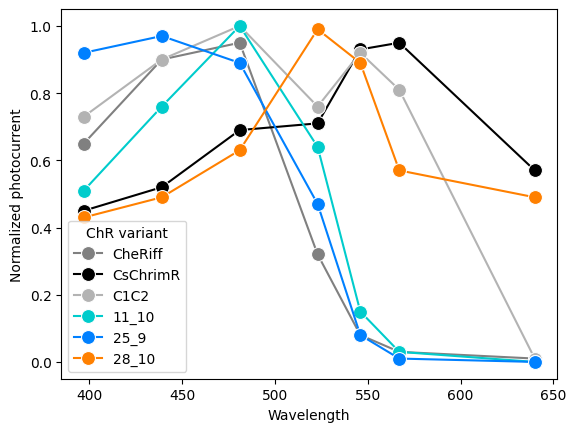

In [56]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
color_map = [cat_map for cat_map in chr_variant_iv.labels if cat_map.type == 'color'][0]
# chr_variant_order = [k for k,v in chr_variant_iv.labels.items() if k in panel_df['ChR variant'].unique()]
# palette = [np.array(v) for k,v in chr_variant_iv.labels.items() if k in chr_variant_order]

# color_map = [cat_map for cat_map in chr_variant_iv.category_maps if cat_map.type == 'color'][0]
chr_variant_order = [k for k,v in color_map.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v) for k,v in color_map.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
# axes.semilogx()


After comparing the original figure and the recreated plot, here are the three most significant discrepancies:

1. Line style: In the original figure, the lines are dashed, while in the recreated plot, they are solid lines. This is a style difference that doesn't change the interpretation of the data, but it's worth noting.

2. Y-axis label: The original figure labels the y-axis as "Photocurrent [pA]", while the recreated plot uses "Peak photocurrent". This is a minor difference in labeling but doesn't significantly affect the interpretation.

3. ChR variant labels: The original figure uses different labels for the ChR variants compared to the recreated plot. For example, the top-performing variant is labeled as "25_9" in the original, while it's "ChR_25_9" in the recreation. This discrepancy in naming convention is present for all ChR variants.

It's important to note that despite these discrepancies, the overall trends and relative positions of the different ChR variants appear to be

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, here are the three most significant discrepancies:

1. Scale of Peak Photocurrent: The original figure shows peak photocurrent values up to about 2500 pA, while the recreated plot only goes up to about 1000 pA. This is a major discrepancy that affects the interpretation of the data, as it significantly underrepresents the magnitude of the photocurrents for most variants.

2. Missing Data Series: The recreated plot is missing several ChR variants that are present in the original figure. The original shows at least 7 distinct data series, while the recreated plot only shows 6. Notably, the top-performing variants (likely corresponding to ChR_25_9, ChR_11_10, and ChR_28_10) are either missing or severely underrepresented in the recreated plot.

3. Trend Discrepancies: The trends for some variants differ significantly between the two plots. For example, in the original figure, most variants show an increase in photocurrent as ligh

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


KeyboardInterrupt: 

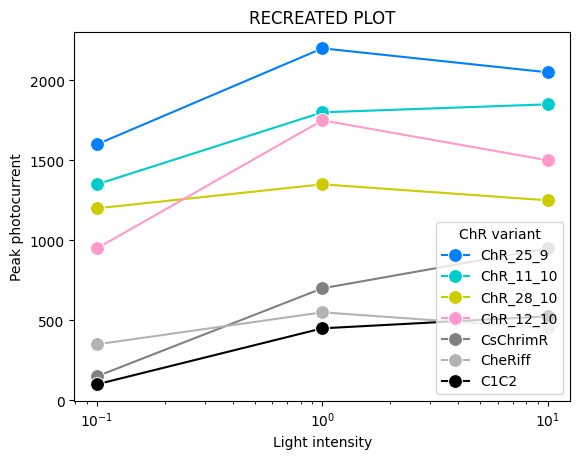

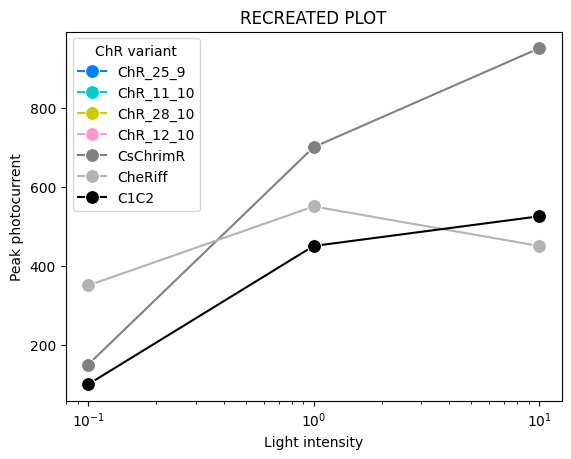

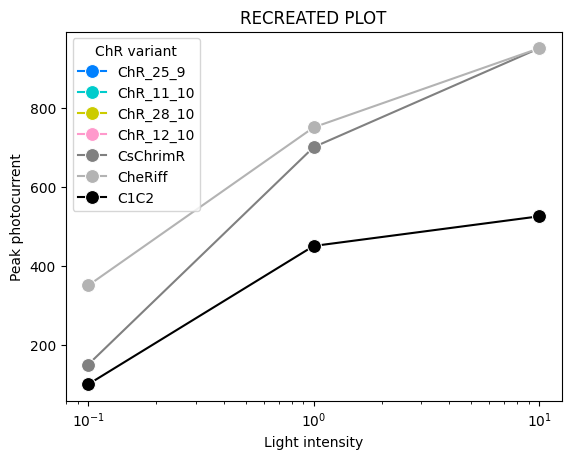

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image


fig, axes = plt.subplots()
# sns.lineplot(
#     data=panel_df,
#     x='Wavelength',
#     y='Normalized photocurrent',
#     hue='ChR variant',
#     marker='o',
#     hue_order=chr_variant_order,
#     markersize=10,
#     palette=palette,
#     ax=axes
# )
# sns.lineplot(
#     data=panel_df,
#     x='Light intensity (mW mm^-2)',
#     y='Spike fidelity (%)',
#     hue='ChR variant',
#     marker='o',
#     hue_order=chr_variant_order,
#     markersize=10,
#     palette=palette,
#     ax=axes
# )
# axes.semilogx()
axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Peak photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.semilogx()

axes.set_title(f"RECREATED PLOT")
# axes.set_xscale('log')

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

refined_feedback = "No previous changes."
claude_mm_critique = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620", temperature=0.1)
for iter in range(20):

    


    prompt_base = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most significant discrepancies between the two plots.
If a style label is incorrect, note that, but do not worry about minor differences in style or differences that don't change the interpretation of the data.

DataFrame:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm_critique.message(prompt_base, images = [cropped_img, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    refined_feedback = feedback_loop

    # refined_feedback_response = claude_mm_default.message(
    #     f"Choose the two most important changes from the suggested list that will result in the largest quantitative improvement in matching the source figure: \n{feedback_loop}",
    #     images = [cropped_img, generated_img_loop]
    # )
    # refined_feedback = refined_feedback_response.content[0].text
    # print(refined_feedback)



    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
You were previously given the following task:
"In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?"

Here is you the dataframe output from your previous response:
{df_table}

And here is some information that could be useful:
{text_info}

We have reviewed your response and notice these important changes that will improve the match to the source figure:
{feedback}

Please revise your response by incorporating these changes. 
Adjust the values in the dataframe in the most parsimonious way possible to match the source figure.
Reference the source text in the context if you think there is information that will inform these changes (e.g changing independent variable values).
This could mean scaling or shift all or a subset of the rows and/or columns, but do not add or delete rows.
Please let any specific changes inform nearby values if that is necessary to match the source figure.

And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.

Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
        text_info = details_text,
    ).replace("{","<").replace("}",">")
    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = claude_mm_critique.message(prompt, images = [cropped_img, generated_img_loop])
    panel_df_loop = output_parser.parse(data_response_loop.content[0].text).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Wavelength',
    #     y='Normalized photocurrent',
    #     hue='ChR variant',
    #     marker='o',
    #     hue_order=chr_variant_order,
    #     markersize=10,
    #     palette=palette,
    #     ax=axes
    # )
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Light intensity (mW mm^-2)',
    #     y='Spike fidelity (%)',
    #     hue='ChR variant',
    #     marker='o',
    #     hue_order=chr_variant_order,
    #     markersize=10,
    #     palette=palette,
    #     ax=axes
    # )
    # axes.semilogx()
    axes = sns.lineplot(
        data=panel_df_loop,
        x='Light intensity',
        y='Peak photocurrent',
        hue='ChR variant',
        marker='o',
        hue_order=chr_variant_order,
        markersize=10,
        palette=palette
    )
    axes.semilogx()
    axes.set_title(f"RECREATED PLOT")
    # axes.set_xscale('log')

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

In [ ]:
panel_df_loop

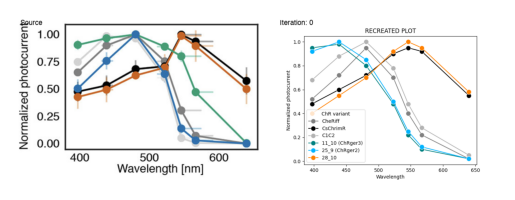

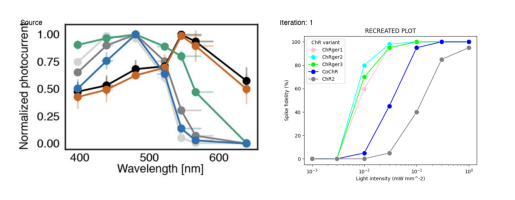

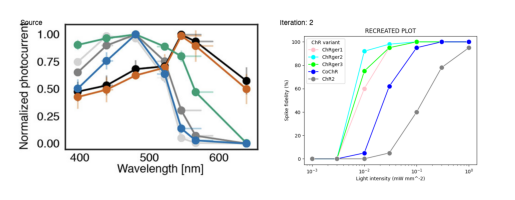

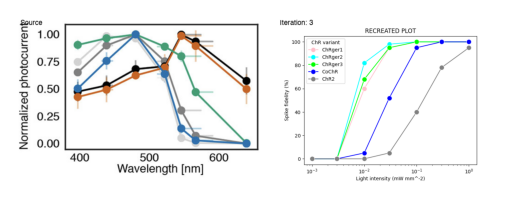

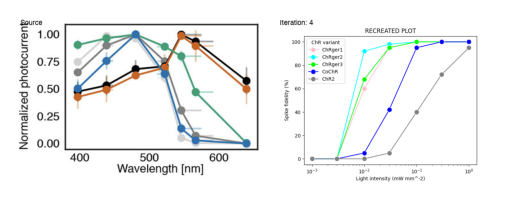

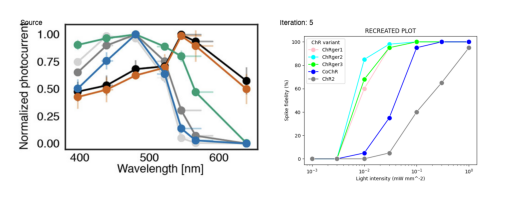

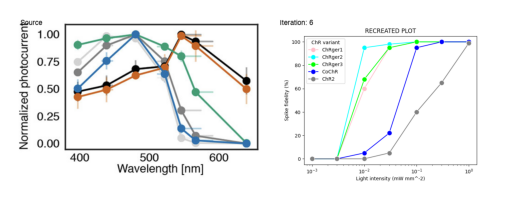

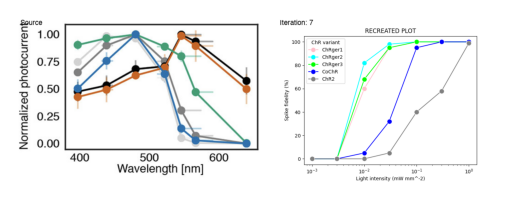

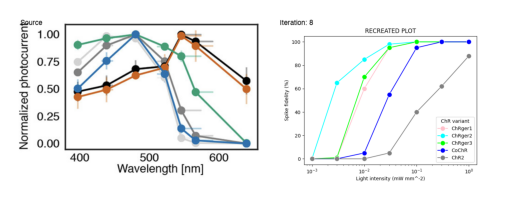

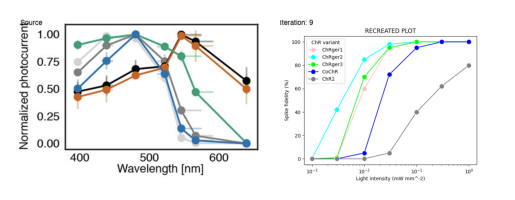

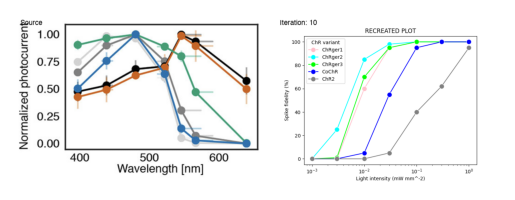

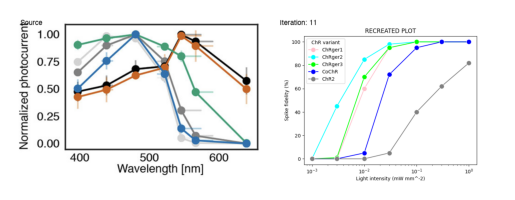

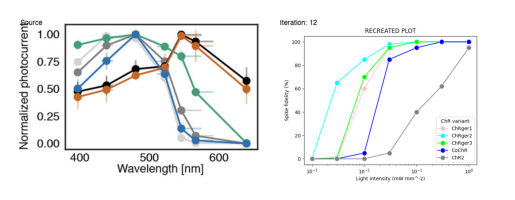

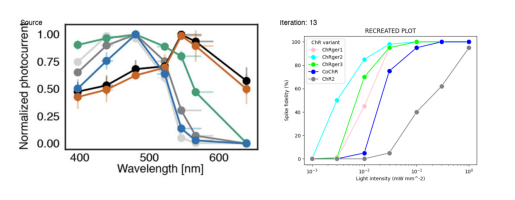

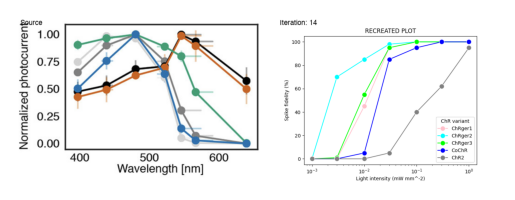

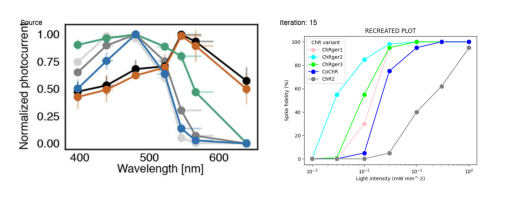

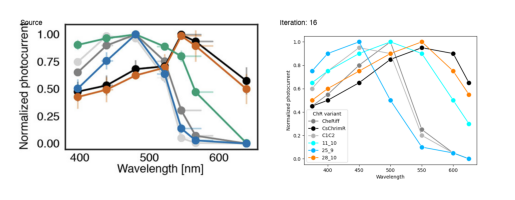

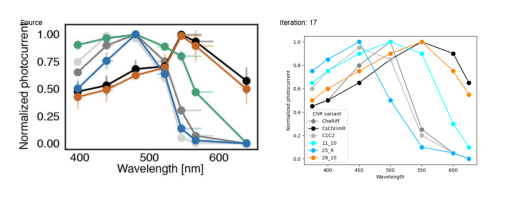

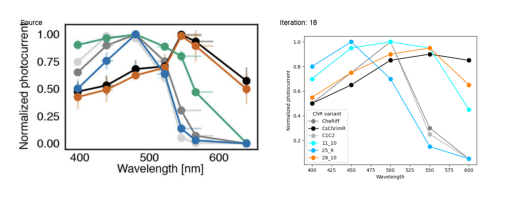

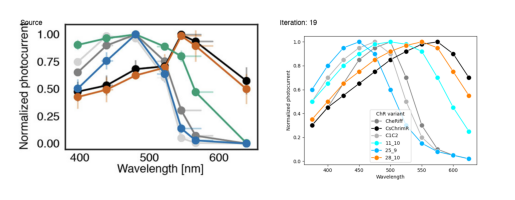

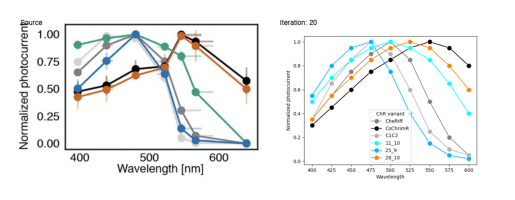

MP4 video saved as 'comparison.mp4'


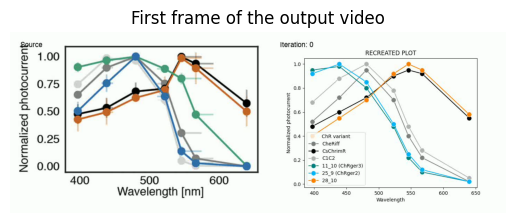

In [ ]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/2d_screenshot.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(21):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")
